In [655]:
import os
import pandas as pd
import numpy as np
import talib
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import optuna
import pickle

from optuna.logging import set_verbosity
set_verbosity(optuna.logging.WARNING)

pd.set_option('display.max_columns', None) 

In [602]:
# データの読み込み
def load_data(file_names):
    dfs = []
    for file_name in file_names:
        df = pd.read_csv(file_name)
        dfs.append(df)
    return dfs

## 対数化
- 対数化は、データの値を対数変換することによって、分布の歪みを軽減するために行う
- この処理は、正規分布に近づけることで機械学習モデルの精度を向上させるために行われる

## 標準化
- 標準化は、データの平均値を0に、標準偏差を1にするように変換することで、異なる尺度のデータを比較可能にするために行う
- この処理は、異なる尺度の特徴量を扱う際に、データのバランスを取るために行われる

- 対数化はデータの分布を整えることを目的とし、標準化はデータのスケールを統一することを目的としている
- どちらの処理も、データの前処理として機械学習モデルの精度向上に役立つ

In [635]:
# 特徴量エンジニアリング
def feature_engineering(df, prefix):
    open = df[f'{prefix}_open'].values
    high = df[f'{prefix}_high'].values
    low = df[f'{prefix}_low'].values
    close = df[f'{prefix}_close'].values
    volume = df[f'{prefix}_volume'].values
    hilo = (high + low) / 2

    # TA-Libを使用して一般的なテクニカル指標を計算
    # 標準化：　closeで割る
    # 対数化：　numpyで対数変換する
    df[f'{prefix}_RSI_ST'] = talib.RSI(close)/close
    df[f'{prefix}_RSI_LOG'] = log_transform_feature(talib.RSI(close))
    df[f'{prefix}_MACD'], _, _ = talib.MACD(close)
    df[f'{prefix}_MACD_ST'], _, _ = talib.MACD(close)/close
    df[f'{prefix}_ATR'] = talib.ATR(high, low, close)
    # df[f'{prefix}_ADX'] = talib.ADX(high, low, close)
    df[f'{prefix}_SMA10_ST'] = talib.SMA(close, timeperiod=10)/close
    df[f'{prefix}_SMA10_LOG'] = log_transform_feature(talib.SMA(close, timeperiod=10))
    df[f'{prefix}_SMA50_ST'] = talib.SMA(close, timeperiod=50)/close
    df[f'{prefix}_SMA50_LOG'] = log_transform_feature(talib.SMA(close, timeperiod=50))
    df[f'{prefix}_SMA100_ST'] = talib.SMA(close, timeperiod=100)/close
    df[f'{prefix}_SMA100_LOG'] = log_transform_feature(talib.SMA(close, timeperiod=100))
    df[f'{prefix}_SMA200_ST'] = talib.SMA(close, timeperiod=200)/close
    df[f'{prefix}_SMA200_LOG'] = log_transform_feature(talib.SMA(close, timeperiod=200))
    # df[f'{prefix}_EMA'] = talib.EMA(close, timeperiod=30)/close
    df[f'{prefix}_BB_UPPER'], df[f'{prefix}_BB_MIDDLE'], df[f'{prefix}_BB_LOWER'] = talib.BBANDS(close)
    df[f'{prefix}_BBANDS_upperband'] = (df[f'{prefix}_BB_UPPER'] - hilo) / close
    df[f'{prefix}_BBANDS_middleband'] = (df[f'{prefix}_BB_MIDDLE'] - hilo) / close
    df[f'{prefix}_BBANDS_lowerband'] = (df[f'{prefix}_BB_LOWER'] - hilo) / close
    
    df[f'{prefix}_STOCH_K'], df[f'{prefix}_STOCH_D'] = talib.STOCH(high, low, close)/close
    df[f'{prefix}_AD'] = talib.AD(high, low, close, volume)
    df[f'{prefix}_MON'] = talib.MOM(close, timeperiod=5)
    df[f'{prefix}_RCI9'] = RCI(df, prefix, period=9)/close
    df[f'{prefix}_RCI26'] = RCI(df, prefix, period=26)/close
    df[f'{prefix}_RCI52'] = RCI(df, prefix, period=52)/close
    df[f'{prefix}_RCI9_LOG'] = log_transform_feature(RCI(df, prefix, period=9))
    df[f'{prefix}_RCI26_LOG'] = log_transform_feature(RCI(df, prefix, period=26))
    df[f'{prefix}_RCI52_LOG'] = log_transform_feature(RCI(df, prefix, period=52))
    df[f'{prefix}_OBV'] = talib.OBV(close, volume)
    df[f'{prefix}_WMA'] = talib.WMA(close)
    df[f'{prefix}_DEMA'] = talib.DEMA(close)
    df[f'{prefix}_HT_TRENDLINE'] = talib.HT_TRENDLINE(close)
    df[f'{prefix}_APO'] = talib.APO(close)
    df[f'{prefix}_PPO'] = talib.PPO(close)
    df[f'{prefix}_DEMA'] = talib.DEMA(close, timeperiod=30)
    df[f'{prefix}_WMA'] = talib.WMA(close, timeperiod=30)
    df[f'{prefix}_LINEARREG'] = talib.LINEARREG(close, timeperiod=14)/close
    df[f'{prefix}_CMO'] = talib.CMO(close, timeperiod=14)/close
    df[f'{prefix}_WILLR'] = talib.WILLR(high, low, close, timeperiod=14)
    df[f'{prefix}_OBV'] = talib.OBV(close, volume)
        
#         DF["OBV"]=0.0
#     volume=np.array(DF["expVolume"])
#     obv=talib.OBV(close,volume)
    # df[f'{prefix}_OBV'] = talib.OBV(close)
    
    # # ラグ特徴量
    df[f'{prefix}_lag1'] = df[f'{prefix}_close'].shift(1)
    df[f'{prefix}_lag2'] = df[f'{prefix}_close'].shift(2)


    # 欠損値の削除
    df = df.dropna()
    df = df.reset_index(drop=True)

    return df

# X: 特徴量の行列 (2次元ndarray)
def log_transform_feature(X):
    # ゼロ以下の値を持つ場合は、値を補正してから対数変換する
    X[X <= 0] = np.finfo(float).eps
    # 特徴量の対数変換を行う
    return np.log(X)

# 結合のデータフレームに特徴量を追加
# def add_features(df):
#     df.set_index('15m_timestamp', inplace=True)
#     df.index = pd.to_datetime(df.index)
#     df['weekday'] = df.index.weekday
#     df['month'] = df.index.month
#     df['year'] = df.index.year
    
#     return df

def RCI(df, prefix, period=9):
    def rank(series):
        temp = series.argsort()
        ranks = np.empty_like(temp)
        ranks[temp] = np.arange(len(series))
        return len(series) - ranks

    def calculate_rci(prices, period):
        r = np.sum((rank(prices) - rank(np.roll(prices, period))) ** 2)
        return 1 - 6 * r / (period * (period ** 2 - 1))

    return df[f'{prefix}_close'].rolling(window=period).apply(calculate_rci, args=(period,), raw=True)

In [611]:
# ラベルデータ作成
def create_label(df, prefix, lookahead=1):
    df[f'{prefix}_target'] = (df[f'{prefix}_close'].shift(-lookahead) > df[f'{prefix}_close']).astype(int)
    df = df.dropna()
    return df

In [647]:
# 学習曲線のグラフを表示する関数
def plot_learning_curve(evals_result):
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(np.arange(len(evals_result['training']['binary_error'])),
            evals_result['training']['binary_error'], label='Training')
    ax.plot(np.arange(len(evals_result['valid_1']['binary_error'])),
            evals_result['valid_1']['binary_error'], label='Validation')
    ax.set_title('Learning Curve')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Binary Error')
    ax.legend()
    plt.show()

# 特徴量の重要度を表示する関数
def plot_feature_importance(model, feature_names):
    importance = pd.DataFrame({"Feature": feature_names,
                               "Importance": model.feature_importance()})
    importance.sort_values(by="Importance", ascending=False, inplace=True)
    plt.figure(figsize=(10, 10))
    sns.barplot(x="Importance", y="Feature", data=importance)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()

In [649]:
def prepare_data(df):
    # 特徴量とラベルを分割
    features = df.drop("15m_target", axis=1)
    labels = df["15m_target"]

    # データを訓練用と検証用に分割
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)
    
    return X_train, X_val, y_train, y_val

# Optunaで最適化
def objective(trial, df):
    X_train, X_val, y_train, y_val = prepare_data(df)
    # ハイパーパラメータ
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
    }

    model = lgb.train(
        params,
        lgb.Dataset(X_train, label=y_train),
        valid_sets=[lgb.Dataset(X_val, label=y_val)],
        verbose_eval=False,
        early_stopping_rounds=10,
    )
    
    val_preds = model.predict(X_val, num_iteration=model.best_iteration)
    score = accuracy_score(y_val, np.round(val_preds))
    
    return score


# 学習と評価
def train_and_evaluate(df, study):
    features = df.drop(['15m_target', '1h_timestamp', '4h_timestamp'], axis=1)
    labels = df['15m_target']

    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

    # 最適化されたハイパーパラメータでモデルを訓練
    train_data = lgb.Dataset(X_train, label=y_train)
    test_data = lgb.Dataset(X_test, label=y_test)

    best_params = study.best_params
    evals_result = {}

    model = lgb.train(
        params={**best_params, 'metric': 'binary_error'},
        train_set=train_data,
        valid_sets=[train_data, test_data],
        num_boost_round=10000,
        verbose_eval=0,
        early_stopping_rounds=10,
        evals_result=evals_result
    )

    y_pred = model.predict(X_test)
    y_pred = np.round(y_pred).astype(int)

    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy}")
    print(classification_report(y_test, y_pred))
    
    # 学習曲線のグラフを表示
    plot_learning_curve(evals_result)

    # 特徴量の重要度を表示
    plot_feature_importance(model, features.columns)

    return model, evals_result

,15m_timestamp,15m_open,15m_high,15m_low,15m_close,15m_volume,15m_RSI_ST,15m_RSI_LOG,15m_MACD,15m_MACD_ST,15m_ATR,15m_SMA10_ST,15m_SMA10_LOG,15m_SMA50_ST,15m_SMA50_LOG,15m_SMA100_ST,15m_SMA100_LOG,15m_SMA200_ST,15m_SMA200_LOG,15m_BB_UPPER,15m_BB_MIDDLE,15m_BB_LOWER,15m_BBANDS_upperband,15m_BBANDS_middleband,15m_BBANDS_lowerband,15m_STOCH_K,15m_STOCH_D,15m_AD,15m_MON,15m_RCI9,15m_RCI26,15m_RCI52,15m_RCI9_LOG,15m_RCI26_LOG,15m_RCI52_LOG,15m_OBV,15m_WMA,15m_DEMA,15m_HT_TRENDLINE,15m_APO,15m_PPO,15m_LINEARREG,15m_CMO,15m_WILLR,15m_lag1,15m_lag2,15m_target,1h_timestamp,1h_open,1h_high,1h_low,1h_close,1h_volume,1h_RSI_ST,1h_RSI_LOG,1h_MACD,1h_MACD_ST,1h_ATR,1h_SMA10_ST,1h_SMA10_LOG,1h_SMA50_ST,1h_SMA50_LOG,1h_SMA100_ST,1h_SMA100_LOG,1h_SMA200_ST,1h_SMA200_LOG,1h_BB_UPPER,1h_BB_MIDDLE,1h_BB_LOWER,1h_BBANDS_upperband,1h_BBANDS_middleband,1h_BBANDS_lowerband,1h_STOCH_K,1h_STOCH_D,1h_AD,1h_MON,1h_RCI9,1h_RCI26,1h_RCI52,1h_RCI9_LOG,1h_RCI26_LOG,1h_RCI52_LOG,1h_OBV,1h_WMA,1h_DEMA,1h_HT_TRENDLINE,1h_APO,1h_PPO,1h_LINEARREG,1h_CMO,1h_WILLR,1h_lag1,1h_lag2,1h_target,4h_timestamp,4h_open,4h_high,4h_low,4h_close,4h_volume,4h_RSI_ST,4h_RSI_LOG,4h_MACD,4h_MACD_ST,4h_ATR,4h_SMA10_ST,4h_SMA10_LOG,4h_SMA50_ST,4h_SMA50_LOG,4h_SMA100_ST,4h_SMA100_LOG,4h_SMA200_ST,4h_SMA200_LOG,4h_BB_UPPER,4h_BB_MIDDLE,4h_BB_LOWER,4h_BBANDS_upperband,4h_BBANDS_middleband,4h_BBANDS_lowerband,4h_STOCH_K,4h_STOCH_D,4h_AD,4h_MON,4h_RCI9,4h_RCI26,4h_RCI52,4h_RCI9_LOG,4h_RCI26_LOG,4h_RCI52_LOG,4h_OBV,4h_WMA,4h_DEMA,4h_HT_TRENDLINE,4h_APO,4h_PPO,4h_LINEARREG,4h_CMO,4h_WILLR,4h_lag1,4h_lag2,4h_target
0,1627923600000,39813.76,39880.66,39632.47,39661.93,0.174250,0.001270,3.919780,51.053205,0.001287,192.770271,1.002116,10.590260,1.000053,10.588200,1.009899,10.597998,1.029959,10.617666,39958.946842,39786.962,39614.977158,0.005103,0.000766,-0.003570,0.000939,0.001391,-13.217061,-43.48,0.000025,0.000025,0.000025,0.0,0.0,0.0,-21.411204,39613.019914,39619.061200,39598.556765,166.553205,0.421077,1.003786,0.000020,-56.276920,39813.76,39779.08,1,1.628464e+12,44201.21,44452.77,43676.82,43807.74,13.693585,0.001078,3.854878,14.072833,0.000321,582.414491,1.001374,10.688938,1.001292,10.688857,0.960107,10.646855,0.933131,10.618356,44410.560633,43956.444,43502.327367,0.007893,-0.002473,-0.012839,0.001588,0.001554,-6.230848,216.51,0.000023,0.000023,0.000023,0.0,0.0,0.0,-50.218680,44161.473935,44377.634225,44257.634000,-234.890897,-0.530792,0.998250,-0.000127,-72.611731,44201.21,44256.35,0.0,1.630613e+12,49270.31,49809.71,49231.18,49231.18,42.787260,0.001182,4.063858,400.775672,0.008141,805.495813,0.994110,10.798375,0.977522,10.781548,0.972698,10.776601,0.927696,10.729231,50213.523722,49577.510,48941.496278,0.014078,0.001159,-0.011760,0.000742,0.001222,292.397701,-306.05,0.000020,0.000020,0.000020,0.0,0.0,0.0,-55.900882,48374.795290,48754.175593,48161.517799,436.338205,0.905334,1.015385,0.000333,-28.632984,49270.31,49496.94,1.0
1,1627925400000,39758.37,39806.92,39680.40,39720.61,0.149088,0.001329,3.966204,48.597733,0.001223,189.357394,1.000866,10.590491,0.998597,10.588222,1.008118,10.597711,1.028219,10.617454,39959.349272,39780.360,39601.370728,0.005430,0.000924,-0.003582,0.000779,0.001102,-13.271384,-33.01,0.000025,0.000025,0.000025,0.0,0.0,0.0,-21.262116,39622.891161,39629.567263,39619.948350,175.533782,0.443776,1.001968,0.000140,-56.166996,39661.93,39813.76,0,1.628471e+12,43180.58,43349.71,42820.94,43105.47,6.731396,0.000906,3.664838,-59.871776,-0.001389,611.299170,1.015844,10.687125,1.017756,10.689005,0.976539,10.647665,0.948545,10.618580,44660.119817,43838.024,43015.928183,0.036534,0.017462,-0.001610,0.000970,0.001424,-5.717945,-592.10,0.000023,0.000023,0.000023,0.0,0.0,0.0,-56.950076,44091.696710,44244.315295,44231.166967,-358.545641,-0.810883,1.009691,-0.000508,-87.856686,43807.74,44201.21,1.0,1.630642e+12,49447.47,49730.23,49226.00,49251.72,38.248366,0.001185,4.066987,400.942306,0.008141,783.976826,0.996908,10.801603,0.977332,10.781771,0.972779,10.777101,0.928115,10.730100,50063.445351,4

/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/optuna/progress_bar.py:56: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()
  0%|                                                                                                                                                                                                                                                                                     | 0/100 [00:00<?, ?it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: Futu

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 0. Best value: 0.464226:   2%|████▋                                                                                                                                                                                                                                   | 2/100 [00:00<00:18,  5.37it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008


Best trial: 0. Best value: 0.464226:   3%|██████▉                                                                                                                                                                                                                                 | 3/100 [00:00<00:14,  6.72it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002198 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008


Best trial: 0. Best value: 0.464226:   4%|█████████▎                                                                                                                                                                                                                              | 4/100 [00:00<00:22,  4.35it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004129 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 0. Best value: 0.464226:   5%|███████████▌                                                                                                                                                                                                                            | 5/100 [00:01<00:35,  2.66it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 5. Best value: 0.470882:   6%|█████████████▉                                                                                                                                                                                                                          | 6/100 [00:02<00:46,  2.01it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 9. Best value: 0.527454:  11%|█████████████████████████▍                                                                                                                                                                                                             | 11/100 [00:03<00:18,  4.73it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 9. Best value: 0.527454:  14%|████████████████████████████████▎                                                                                                                                                                                                      | 14/100 [00:03<00:14,  5.81it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set

Best trial: 9. Best value: 0.527454:  15%|██████████████████████████████████▋                                                                                                                                                                                                    | 15/100 [00:03<00:18,  4.49it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001854 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 15. Best value: 0.552413:  16%|████████████████████████████████████▊                                                                                                                                                                                                 | 16/100 [00:04<00:21,  3.87it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 15. Best value: 0.552413:  18%|█████████████████████████████████████████▍                                                                                                                                                                                            | 18/100 [00:04<00:25,  3.23it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

Best trial: 15. Best value: 0.552413:  19%|███████████████████████████████████████████▋                                                                                                                                                                                          | 19/100 [00:05<00:30,  2.64it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004017 seconds.

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromSco

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001723 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 15. Best value: 0.552413:  23%|████████████████████████████████████████████████████▉                                                                                                                                                                                 | 23/100 [00:06<00:18,  4.10it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 15. Best value: 0.552413:  26%|███████████████████████████████████████████████████████████▊                                                                                                                                                                          | 26/100 [00:07<00:24,  3.03it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003895 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromSco

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 28. Best value: 0.574043:  29%|██████████████████████████████████████████████████████████████████▋                                                                                                                                                                   | 29/100 [00:07<00:17,  4.16it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set

Best trial: 28. Best value: 0.574043:  30%|█████████████████████████████████████████████████████████████████████                                                                                                                                                                 | 30/100 [00:08<00:14,  4.67it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 28. Best value: 0.574043:  32%|█████████████████████████████████████████████████████████████████████████▌                                                                                                                                                            | 32/100 [00:08<00:12,  5.23it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number 

Best trial: 28. Best value: 0.574043:  33%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                                          | 33/100 [00:08<00:12,  5.23it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004766 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

Best trial: 28. Best value: 0.574043:  34%|██████████████████████████████████████████████████████████████████████████████▏                                                                                                                                                       | 34/100 [00:08<00:11,  5.52it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004663 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008


/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004635 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 28. Best value: 0.574043:  36%|██████████████████████████████████████████████████████████████████████████████████▊                                                                                                                                                   | 36/100 [00:09<00:18,  3.43it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008


Best trial: 28. Best value: 0.574043:  38%|███████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                                              | 38/100 [00:09<00:18,  3.44it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003929 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008


Best trial: 28. Best value: 0.574043:  39%|█████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                                            | 39/100 [00:10<00:20,  3.01it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004035 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 28. Best value: 0.574043:  40%|████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                                          | 40/100 [00:11<00:25,  2.38it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004226 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positi

Best trial: 28. Best value: 0.574043:  41%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                       | 41/100 [00:11<00:23,  2.48it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 28. Best value: 0.574043:  43%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                   | 43/100 [00:11<00:15,  3.58it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004127 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 28. Best value: 0.574043:  45%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                              | 45/100 [00:12<00:11,  4.68it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 28. Best value: 0.574043:  46%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                            | 46/100 [00:12<00:11,  4.83it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
Best trial: 28. Best value: 0.574043:  47%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                               

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008


/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004073 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899


Best trial: 28. Best value: 0.574043:  50%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 50/100 [00:12<00:09,  5.04it/s]

[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 28. Best value: 0.574043:  52%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                              | 52/100 [00:13<00:08,  5.94it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004604 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [

/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
Best trial: 28. Best value: 0.574043:  54%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008


Best trial: 28. Best value: 0.574043:  55%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 55/100 [00:13<00:10,  4.46it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001844 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004000 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [

Best trial: 28. Best value: 0.574043:  57%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                   | 57/100 [00:14<00:08,  5.18it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004622 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set

Best trial: 28. Best value: 0.574043:  58%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                | 58/100 [00:14<00:12,  3.48it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 28. Best value: 0.574043:  60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                            | 60/100 [00:15<00:09,  4.43it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 28. Best value: 0.574043:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                     | 63/100 [00:15<00:07,  5.21it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004731 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set

Best trial: 28. Best value: 0.574043:  65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 65/100 [00:16<00:08,  4.03it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001446 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 28. Best value: 0.574043:  67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 67/100 [00:16<00:09,  3.59it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 28. Best value: 0.574043:  69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 69/100 [00:17<00:06,  4.63it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008


Best trial: 28. Best value: 0.574043:  70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                     | 70/100 [00:17<00:06,  4.50it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004504 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 28. Best value: 0.574043:  71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                  | 71/100 [00:17<00:08,  3.23it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008


/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004943 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008


/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001471 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008


Best trial: 28. Best value: 0.574043:  75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 75/100 [00:18<00:07,  3.55it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004524 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [

Best trial: 28. Best value: 0.574043:  77%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                     | 77/100 [00:19<00:07,  3.18it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008


Best trial: 28. Best value: 0.574043:  78%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                  | 78/100 [00:19<00:08,  2.70it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001681 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173


/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback v

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008


Best trial: 28. Best value: 0.574043:  81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 81/100 [00:20<00:06,  3.16it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 81. Best value: 0.585691:  83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 83/100 [00:21<00:04,  4.06it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
Best trial: 81. Best value: 0.585691:  84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004008 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 81. Best value: 0.585691:  85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                  | 85/100 [00:21<00:04,  3.60it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005747 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 81. Best value: 0.585691:  88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                           | 88/100 [00:22<00:02,  4.77it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 81. Best value: 0.585691:  89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 89/100 [00:22<00:02,  4.34it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004481 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 81. Best value: 0.585691:  91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 91/100 [00:22<00:01,  5.54it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001955 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 81. Best value: 0.585691:  94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 94/100 [00:23<00:01,  5.11it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003884 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

Best trial: 81. Best value: 0.585691:  96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 96/100 [00:24<00:01,  3.68it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Info] Number of data points in the train set: 2400, number of used features: 131
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.511250 -> initscore=0.045008
[LightGBM] [Info] Start training from score 0.045008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 81. Best value: 0.585691:  98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 98/100 [00:24<00:00,  4.59it/s]/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': tr

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of positive: 1227, number of negative: 1173
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 32899
[LightGBM] [Info] Number of data points in the train set

Best trial: 81. Best value: 0.585691:  99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 99/100 [00:24<00:00,  4.47it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:19: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'learning_rate': trial.suggest_loguniform('learning_rate', 1e-8, 1.0),
/var/folders/m1/5dpmkc_567gddy0b98vly1w40000gn/T/ipykernel_89148/906844673.py:20: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callback

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Best trial: 81. Best value: 0.585691: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.99it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f


/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "
/Users/tek/dev/python/learning-model/myenv/lib/python3.11/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' ca

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

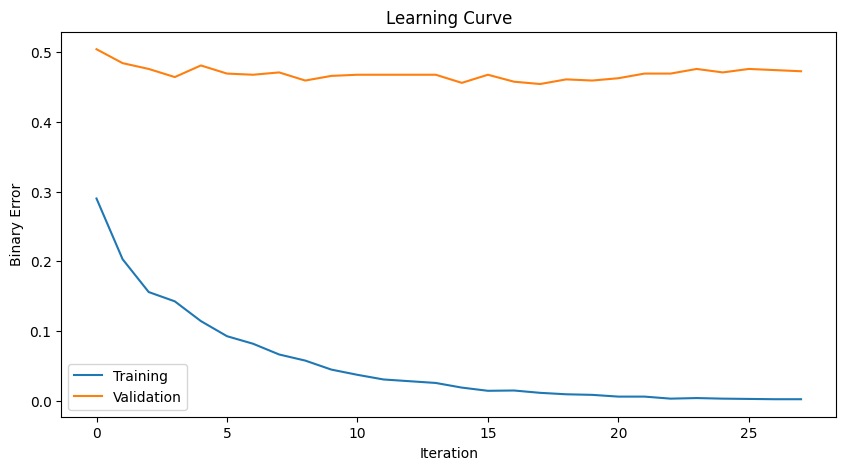

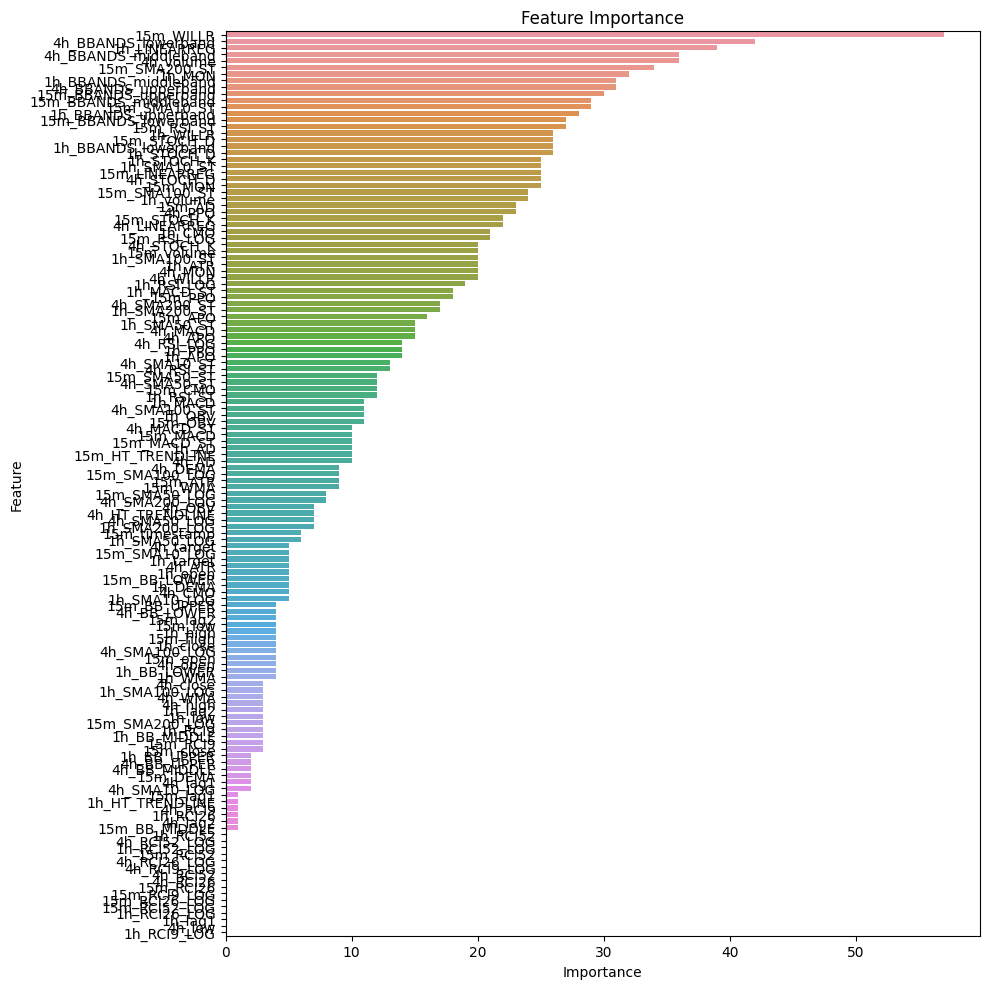

Model saved to model/model.pkl


In [656]:
if __name__ == "__main__":
    file_names = [
        "data/BTCUSDT_15m_20210801_20221231.csv", 
        "data/BTCUSDT_1h_20210801_20221231.csv", 
        "data/BTCUSDT_4h_20210801_20221231.csv"]
    dfs = load_data(file_names)

    # 各タイムフレームのデータに対して特徴量エンジニアリングとラベル作成を行う
    processed_dfs = []
    for df in dfs:
        prefix = df.columns[0].split('_')[0]  # カラム名のプレフィックスを取得（例：15m）
        processed_df = feature_engineering(df, prefix)
        processed_df = create_label(processed_df, prefix)
        processed_dfs.append(processed_df)

    # 複数のタイムフレームのデータを結合（インデックスが一致するように注意）
    combined_df = pd.concat(processed_dfs, axis=1).dropna()
    display(combined_df)

    # Optunaで最適化
    study = optuna.create_study(direction="maximize")
    study.optimize(lambda trial: objective(trial, combined_df), n_trials=100, show_progress_bar=True)

    # モデルの学習と評価を行う
    model = train_and_evaluate(combined_df, study)

 
    # モデルを保存する
    model_path = os.path.join("model", "model.pkl")
    with open(model_path, "wb") as f:
        pickle.dump(model, f)

    print(f"Model saved to {model_path}")